In [5]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

In [6]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.relu(self.fc1(state.float()))
        actions = self.fc2(layer1)

        return actions

In [7]:
class Agent():
    def __init__(self,input_dims, n_actions, lr=0.01, gamma=0.99,
                 epsilon=1.0, eps_dec=1e-2, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        T_chws_set.value = action+6
        
        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
              if self.epsilon > self.eps_min else self.eps_min
        
    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.long).to(self.Q.device)
        actions = T.tensor(action, dtype=T.long).to(self.Q.device)
        rewards = T.tensor(reward, dtype=T.long).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.long).to(self.Q.device)

        q_pred = self.Q.forward(states)[actions]

        q_next = self.Q.forward(states_).max()

        q_target = rewards + self.gamma*q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()

        self.Q.optimizer.step()
        self.decrement_epsilon()


Initialization of Arrays

In [8]:
score_history = []
eps_history = []
power_history = []
setpoints_history = []

agent = Agent(input_dims=10, n_actions=10)

for i in range(5):
    empty_array1 = []
    power_history.append(empty_array1)
    empty_array2 = []
    setpoints_history.append(empty_array2)

keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

5 Episodes

In [9]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

for episode in range(5):  
    env = energyplus.ooep.ems.Environment().__enter__()

    sm_env = ooep.addons.state.StateMachine(env)
    sm_stepf = sm_env.step_function(
        dict(event_name='begin_zone_timestep_after_init_heat_balance')
    )

    sm_env.run(
        '--output-directory', 'build3/demo-eplus',
        '--weather', f'./SGP_Singapore_486980_IWEC.epw',
        f'./jan4.idf',
        verbose=True,
    )

    while True:

        sm_stepf()


        try:

            P_ch = [env.variable(dict(
                        variable_name='Chiller Electricity Rate',
                        variable_key=key)) for key in keys]
            power = P_ch[0].value + P_ch[1].value + P_ch[2].value

            print(power)
            break

        except ooep.ems.NotReadyError: pass


    score = 0

    for step in range(1, 7680):
        P_ch = [env.variable(dict(
            variable_name='Chiller Electricity Rate',
            variable_key=key)) for key in keys]
        E_ch = [env.variable(dict(
            variable_name='Chiller Electricity', 
            variable_key=key)) for key in keys]
        T_outdoor = env.variable(dict(
            variable_name='Site Outdoor Air Drybulb Temperature',
            variable_key='ENVIRONMENT'))
        T_chws = [env.variable(dict(
            variable_name='Chiller Evaporator Outlet Temperature', 
            variable_key=key)) for key in keys]
        T_chwr = [env.variable(dict(
            variable_name='Chiller Evaporator Inlet Temperature', 
            variable_key=key)) for key in keys]
        T_chws_set = env.actuator(dict(
            component_type='System Node Setpoint',
            control_type = 'Temperature Setpoint', 
            actuator_key='CHW Loop Supply Side Outlet'))
        
        obs = []
        power_sum = 0

        # Add Chiller Electricity values to the observation space
        for chiller_electricity_rate in P_ch:
            obs.append(chiller_electricity_rate.value)
            power_sum += chiller_electricity_rate.value
        
        obs.append(T_outdoor.value)

        for chiller_evaporator_outlet_temp in T_chws:
            obs.append(chiller_evaporator_outlet_temp.value)

        for chiller_evaporator_inlet_temp in T_chwr:
            obs.append(chiller_evaporator_inlet_temp.value)
        
        if power_sum != 0:
            reward = 120000/ (power_sum)
        else:
            reward = 0

        score += reward

        action = agent.choose_action(obs)
        sm_stepf()

        P_ch_ = [env.variable(dict(
            variable_name='Chiller Electricity Rate',
            variable_key=key)) for key in keys]
        E_ch_ = [env.variable(dict(
            variable_name='Chiller Electricity', 
            variable_key=key)) for key in keys]
        T_outdoor_ = env.variable(dict(
            variable_name='Site Outdoor Air Drybulb Temperature',
            variable_key='ENVIRONMENT'))
        T_chws_ = [env.variable(dict(
            variable_name='Chiller Evaporator Outlet Temperature', 
            variable_key=key)) for key in keys]
        T_chwr_ = [env.variable(dict(
            variable_name='Chiller Evaporator Inlet Temperature', 
            variable_key=key)) for key in keys]
        T_chws_set_ = env.actuator(dict(
            component_type='System Node Setpoint',
            control_type = 'Temperature Setpoint', 
            actuator_key='CHW Loop Supply Side Outlet'))
                
        obs_ = []
        for chiller_electricity_rate in P_ch_:
            obs_.append(chiller_electricity_rate.value)

        obs_.append(T_outdoor_.value)

        for chiller_evaporator_outlet_temp in T_chws_:
            obs_.append(chiller_evaporator_outlet_temp.value)

        for chiller_evaporator_inlet_temp in T_chwr_:
            obs_.append(chiller_evaporator_inlet_temp.value)


        agent.learn(obs, action, reward, obs_)

        print(rf"Episode={episode+1} Step={step}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

        setpoints_history[episode].append(action + 6)
        power_history[episode].append(power_sum)

    eps_history.append(agent.epsilon)
    score_history.append(score)

Episode=1 Step=1  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.9) (T_chws_set=13) 
Episode=1 Step=2  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.9) (T_chws_set=6) 
Episode=1 Step=3  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.9) (T_chws_set=11) 
Episode=1 Step=4  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.799999999999997) (T_chws_set=11) 
Episode=1 Step=5  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.799999999999997) (T_chws_set=9) 
Episode=1 Step=6  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.7) (T_chws_set=6) 


0.0


Episode=1 Step=7  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.625) (T_chws_set=15) 
Episode=1 Step=8  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.625) (T_chws_set=9) 
Episode=1 Step=9  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.549999999999997) (T_chws_set=9) 
Episode=1 Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.549999999999997) (T_chws_set=14) 
Episode=1 Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.549999999999997) (T_chws_set=9) 
Episode=1 Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=10) 
Episode=1 Step=13  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=10) 
Episode=1 Step=14  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=15) 
Episode=1 Step=15  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=12) 
Episode=1 Step=16  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=15) 
Episode=1 Step=17  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.29999999999999

0.0


Episode=2 Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=15) 
Episode=2 Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=15) 
Episode=2 Step=13  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=15) 
Episode=2 Step=14  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=15) 
Episode=2 Step=15  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=15) 
Episode=2 Step=16  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=15) 
Episode=2 Step=17  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=15) 
Episode=2 Step=18  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.299999999999997) (T_chws_set=15) 
Episode=2 Step=19  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.299999999999997) (T_chws_set=15) 
Episode=2 Step=20  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=15) 
Episode=2 Step=21  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=

0.0


Episode=3 Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.549999999999997) (T_chws_set=6) 
Episode=3 Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=6) 
Episode=3 Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=6) 
Episode=3 Step=13  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=6) 
Episode=3 Step=14  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=6) 
Episode=3 Step=15  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=6) 
Episode=3 Step=16  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=6) 
Episode=3 Step=17  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.299999999999997) (T_chws_set=6) 
Episode=3 Step=18  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.299999999999997) (T_chws_set=6) 
Episode=3 Step=19  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=6) 
Episode=3 Step=20  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_

0.0


Episode=4 Step=13  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=6) 
Episode=4 Step=14  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=6) 
Episode=4 Step=15  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=6) 
Episode=4 Step=16  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=6) 
Episode=4 Step=17  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.299999999999997) (T_chws_set=6) 
Episode=4 Step=18  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.299999999999997) (T_chws_set=6) 
Episode=4 Step=19  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=6) 
Episode=4 Step=20  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=6) 
Episode=4 Step=21  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=6) 
Episode=4 Step=22  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.2) (T_chws_set=6) 
Episode=4 Step=23  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.2) (T_chws_set=6) 
Episode=4 Step

0.0


Episode=5 Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=11) 
Episode=5 Step=13  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.474999999999998) (T_chws_set=11) 
Episode=5 Step=14  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.4) (T_chws_set=11) 
Episode=5 Step=15  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=11) 
Episode=5 Step=16  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=11) 
Episode=5 Step=17  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.349999999999998) (T_chws_set=11) 
Episode=5 Step=18  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.299999999999997) (T_chws_set=11) 
Episode=5 Step=19  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=11) 
Episode=5 Step=20  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=11) 
Episode=5 Step=21  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.25) (T_chws_set=11) 
Episode=5 Step=22  P_ch=(0.0, 0.0, 0.0)) Reward=0 (T_outdoor=24.2) (T_chw

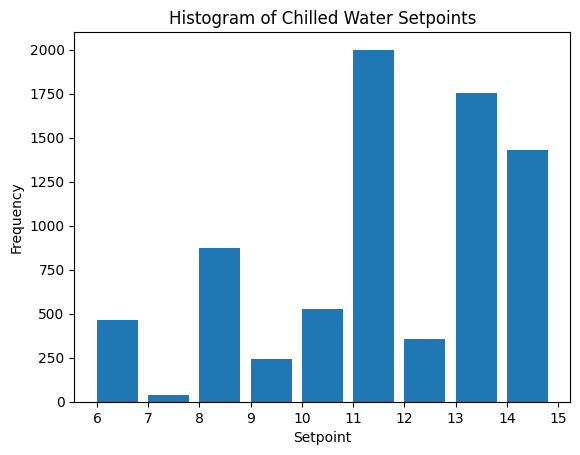

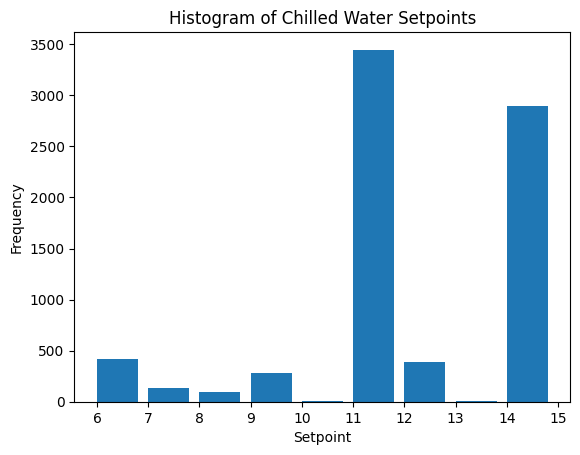

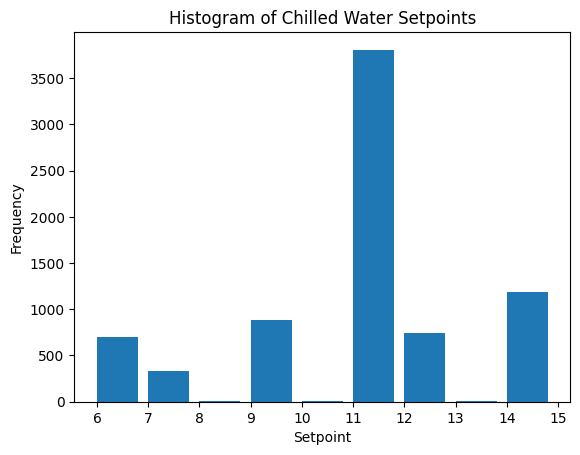

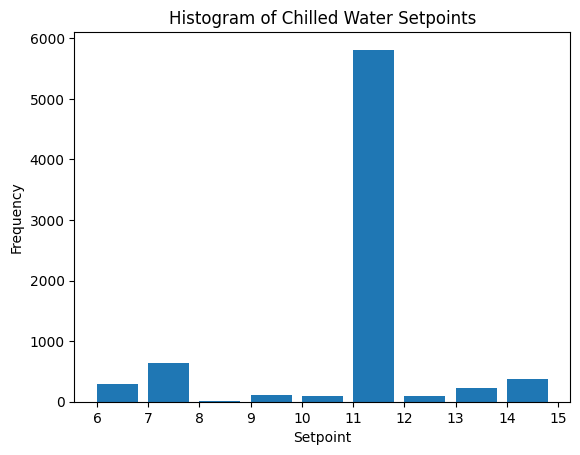

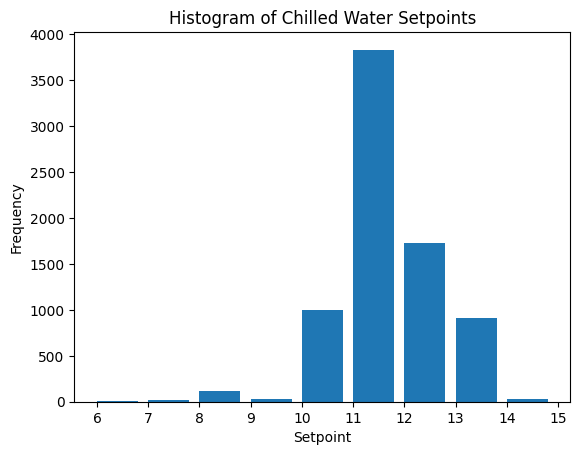

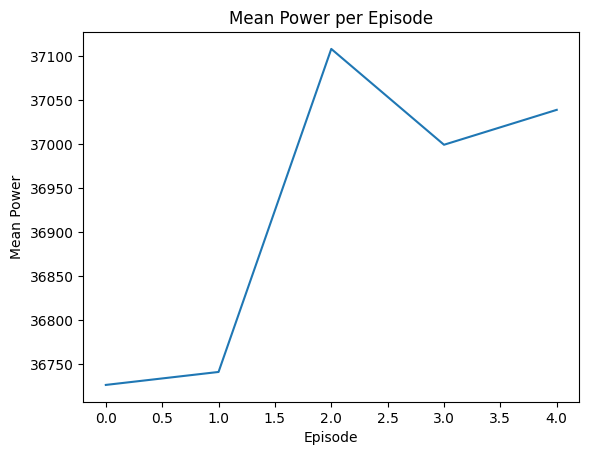

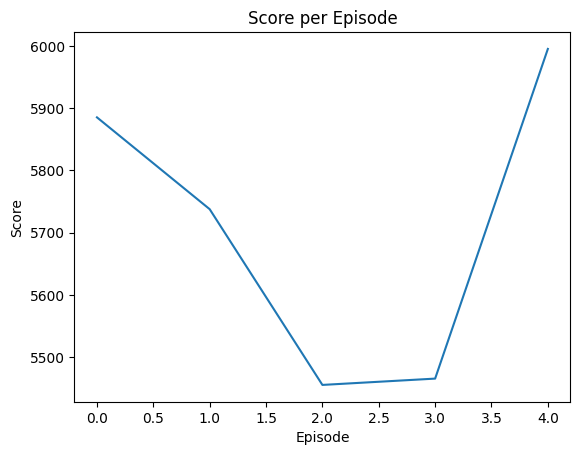

In [17]:
import numpy as np
import matplotlib.pyplot as plt

mean_power_history = []

for episode in range(5):
    mean_power_history.append(np.mean(power_history[episode]))

    '''
    plt.plot(power_history[episode])
    plt.xlabel('Step')
    plt.ylabel('Total Power')
    plt.title('Total Power per Step' + f' (Episode {episode+1})')
    plt.show()
    '''

    counts, bins = np.histogram(setpoints_history[episode], bins=np.arange(6, 16))

    plt.bar(bins[:-1], counts, width=0.8, align='edge')
    plt.xlabel('Setpoint')
    plt.ylabel('Frequency')
    plt.title('Histogram of Chilled Water Setpoints')
    plt.xticks(np.arange(6, 16))
    plt.show()
    

plt.plot(mean_power_history)
plt.xlabel('Episode')
plt.ylabel('Mean Power')
plt.title('Mean Power per Episode')
plt.show()

plt.plot(score_history)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score per Episode')
plt.show()




In [17]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

from energyplus.dataset.basic import dataset as epds

env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./jan4.idf',
    verbose=True,
)


In [18]:

import numpy as np
score_history = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

#agent = Agent(alpha=1e-5, gamma=0.99, n_actions=4)
episode_counter = 0

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass

0.0


In [19]:
score = 0
scores = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

agent = Agent(input_dims=10, n_actions=4)

for i in range(1, 7680):
    P_ch = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value
    powers.append(power)
    obs = []
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        obs.append(chiller_electricity_rate.value)
        power_sum += chiller_electricity_rate.value
    
    obs.append(T_outdoor.value)

    for chiller_evaporator_outlet_temp in T_chws:
        obs.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr:
        obs.append(chiller_evaporator_inlet_temp.value)
    
    reward = 120000/ (power_sum + 10000)

    score += reward

    action = agent.choose_action(obs)
    sm_stepf()

    P_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor_ = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws_ = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr_ = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set_ = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
            
    obs_ = []
    for chiller_electricity_rate in P_ch_:
        obs_.append(chiller_electricity_rate.value)

    obs_.append(T_outdoor_.value)

    for chiller_evaporator_outlet_temp in T_chws_:
        obs_.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr_:
        obs_.append(chiller_evaporator_inlet_temp.value)


    agent.learn(obs, action, reward, obs_)

    print(rf"Step={i}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

    setpoints.append(action + 6)

eps_history.append(agent.epsilon)

scores.append(score)

Step=1  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=9) 
Step=2  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=8) 
Step=3  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=6) 
Step=4  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.799999999999997) (T_chws_set=7) 
Step=5  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=7) 
Step=6  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=7  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=8  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=8) 
Step=9  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=7) 
Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=6) 
Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=7) 
Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.474999999999998) (T_chws_set=6) 
Step=13  P_ch=(0.0, 0.0, 

Mean Power: 36306.985366584064
Median Power: 0.0
Standard Deviation of Power: 47045.65493777059
Minimum Power: 0.0
Maximum Power: 251029.1767051498


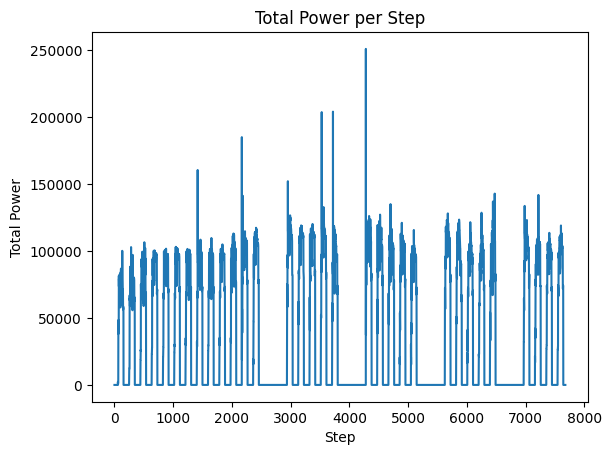

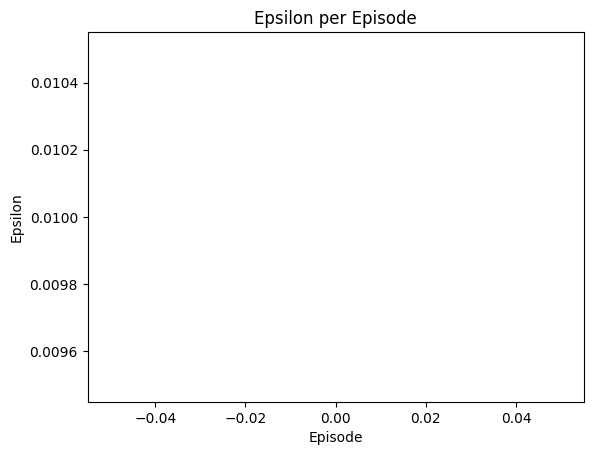

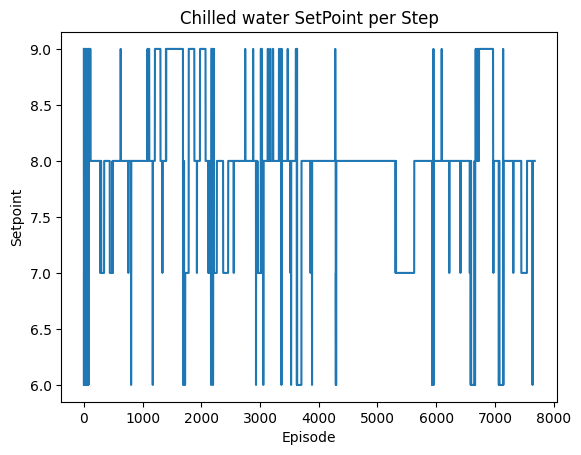

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(powers)
median_power = np.median(powers)
std_power = np.std(powers)
min_power = np.min(powers)
max_power = np.max(powers)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(powers)
plt.xlabel('Step')
plt.ylabel('Total Power')
plt.title('Total Power per Step')
plt.show()

plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode')
plt.show()

plt.plot(setpoints)
plt.xlabel('Episode')
plt.ylabel('Setpoint')
plt.title('Chilled water SetPoint per Step')
plt.show()


In [21]:
print (score)
print (agent.epsilon)

59472.744931816516
0.01


Episode 2

In [22]:
env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./jan4.idf',
    verbose=True,
)

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass


score1 = 0
powers1 = []
setpoints1 = []

for i in range(1, 7680):
    P_ch = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value
    powers1.append(power)
    obs = []
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        obs.append(chiller_electricity_rate.value)
        power_sum += chiller_electricity_rate.value
    
    obs.append(T_outdoor.value)

    for chiller_evaporator_outlet_temp in T_chws:
        obs.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr:
        obs.append(chiller_evaporator_inlet_temp.value)
    
    reward = 120000/ (power_sum + 10000)

    score1 += reward

    action = agent.choose_action(obs)
    sm_stepf()

    P_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor_ = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws_ = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr_ = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set_ = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
            
    obs_ = []
    for chiller_electricity_rate in P_ch_:
        obs_.append(chiller_electricity_rate.value)

    obs_.append(T_outdoor_.value)

    for chiller_evaporator_outlet_temp in T_chws_:
        obs_.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr_:
        obs_.append(chiller_evaporator_inlet_temp.value)


    agent.learn(obs, action, reward, obs_)

    print(rf"Step={i}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

    setpoints1.append(action + 6)

eps_history.append(agent.epsilon)

scores.append(score1)

Step=1  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.000000000000004) (T_chws_set=8) 
Step=2  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=8) 
Step=3  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.799999999999997) (T_chws_set=8) 
Step=4  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.799999999999997) (T_chws_set=8) 
Step=5  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=8) 
Step=6  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=8) 
Step=7  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=8) 
Step=8  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=8) 
Step=9  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=8) 
Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=8) 
Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.474999999999998) (T_chws_set=8) 
Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.474999999999998) (T_chws_set=8) 
Step=13  

0.0


Step=17  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.349999999999998) (T_chws_set=8) 
Step=18  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.299999999999997) (T_chws_set=8) 
Step=19  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.299999999999997) (T_chws_set=8) 
Step=20  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=8) 
Step=21  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=8) 
Step=22  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=8) 
Step=23  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.174999999999997) (T_chws_set=8) 
Step=24  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.174999999999997) (T_chws_set=8) 
Step=25  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.174999999999997) (T_chws_set=8) 
Step=26  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.15) (T_chws_set=8) 
Step=27  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.125000000000004) (T_chws_set=8) 
Step=28  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.125000

Mean Power: 36244.57747521037
Median Power: 0.0
Standard Deviation of Power: 46851.96411978071
Minimum Power: 0.0
Maximum Power: 200493.1167753376


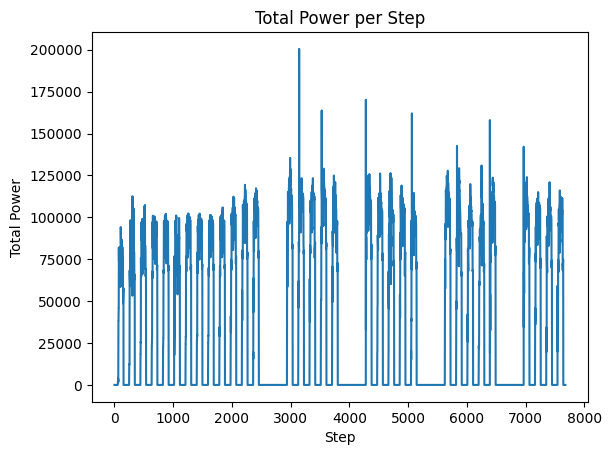

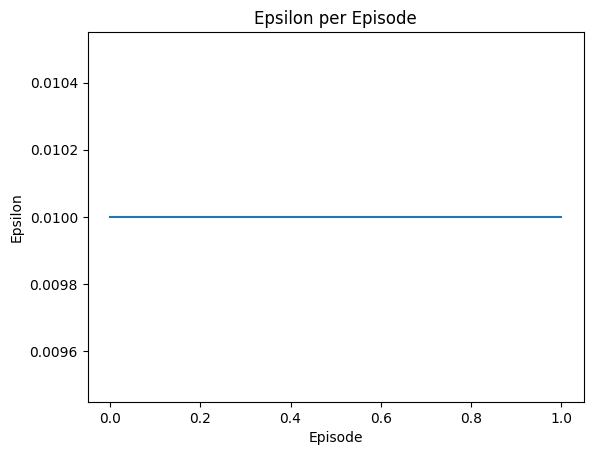

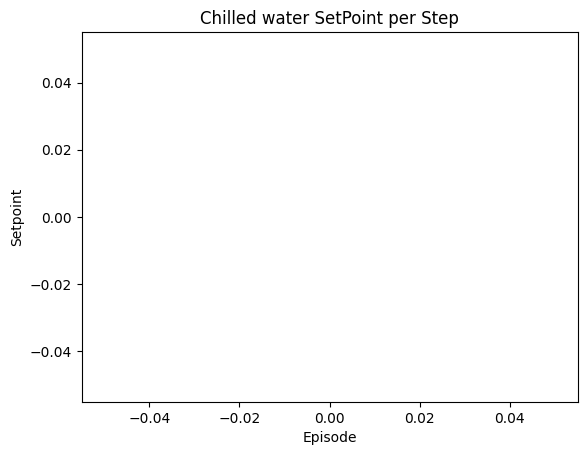

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(powers1)
median_power = np.median(powers1)
std_power = np.std(powers1)
min_power = np.min(powers1)
max_power = np.max(powers1)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(powers1)
plt.xlabel('Step')
plt.ylabel('Total Power')
plt.title('Total Power per Step')
plt.show()

plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode')
plt.show()

plt.plot(setpoints1)
plt.xlabel('Episode')
plt.ylabel('Setpoint')
plt.title('Chilled water SetPoint per Step')
plt.show()


Episode 3

In [25]:
env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./jan4.idf',
    verbose=True,
)

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass


score2 = 0
powers2 = []
setpoints2 = []

for i in range(1, 7680):
    P_ch = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value
    powers2.append(power)
    obs = []
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        obs.append(chiller_electricity_rate.value)
        power_sum += chiller_electricity_rate.value
    
    obs.append(T_outdoor.value)

    for chiller_evaporator_outlet_temp in T_chws:
        obs.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr:
        obs.append(chiller_evaporator_inlet_temp.value)
    
    reward = 120000/ (power_sum + 10000)

    score2 += reward

    action = agent.choose_action(obs)
    sm_stepf()

    P_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor_ = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws_ = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr_ = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set_ = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
            
    obs_ = []
    for chiller_electricity_rate in P_ch_:
        obs_.append(chiller_electricity_rate.value)

    obs_.append(T_outdoor_.value)

    for chiller_evaporator_outlet_temp in T_chws_:
        obs_.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr_:
        obs_.append(chiller_evaporator_inlet_temp.value)


    agent.learn(obs, action, reward, obs_)

    print(rf"Step={i}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

    setpoints2.append(action + 6)

eps_history.append(agent.epsilon)

scores.append(score2)

KeyboardInterrupt: 